In [1]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,ConcatDataset
import math
from torch import nn
from lib.models import RegNet
from torch.nn.functional import relu
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import random
import json
from lib.ekyn import *

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:

PROJECT_DIR = f'projects/17'
with open(f'{PROJECT_DIR}/config.json','r') as f:
    CONFIG = json.load(f)

In [3]:
from lib.models import Dumbledorev2
from lib.datasets import EpochedDataset,SequencedDatasetv2
from lib.ekyn import get_ekyn_ids,load_ekyn_pt

train_idx,test_idx = train_test_split(get_ekyn_ids(),test_size=.25,random_state=0)
# trainloader = DataLoader(ConcatDataset([SequencedDatasetv2(idx=idx,condition=condition,sequence_length=CONFIG['SEQUENCE_LENGTH'],batch_size=CONFIG['BATCH_SIZE']) for idx in train_idx for condition in ['Vehicle','PF']]),batch_size=1,shuffle=True)
# devloader = DataLoader(ConcatDataset([SequencedDatasetv2(idx=idx,condition=condition,sequence_length=CONFIG['SEQUENCE_LENGTH'],batch_size=CONFIG['BATCH_SIZE']) for idx in test_idx for condition in ['Vehicle','PF']]),batch_size=1,shuffle=False)
model = Dumbledorev2(encoder_path=f'projects/6',sequence_length=CONFIG['SEQUENCE_LENGTH'],hidden_dim=CONFIG['HIDDEN_DIM'],layers=CONFIG['LAYERS'],embedding=CONFIG['EMBEDDING'],frozen=CONFIG['FROZEN'],batch_size=CONFIG['BATCH_SIZE'])
model.load_state_dict(torch.load(f=f'{PROJECT_DIR}/best.f1.pt', map_location='cpu'))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=CONFIG['LEARNING_RATE'])
model.to(CONFIG['DEVICE']);

/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
def evaluate(dataloader,model,criterion,DEVICE=DEVICE):
    model.eval()
    model.to(DEVICE)
    criterion.to(DEVICE)
    with torch.no_grad():
        y_true = torch.Tensor()
        y_pred = torch.Tensor()
        y_logits = torch.Tensor()
        loss_total = 0
        for (Xi,yi) in tqdm(dataloader):
            yi = yi.reshape(-1,3)
            y_true = torch.cat([y_true,yi.argmax(axis=1)])


            loss_total += loss.item()
            
            y_logits = torch.cat([y_logits,torch.softmax(logits,dim=1).detach().cpu()])
            y_pred = torch.cat([y_pred,])
    model.train()
    return loss_total/len(dataloader),metrics(y_true,y_pred),y_true,y_pred,y_logits

In [47]:
def get_y_true_y_pred_from_dataloader_and_model(dataloader,model,criterion,device):
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        y_logits = []
        for i,(Xi,yi) in enumerate(dataloader):
            y_true.append(yi)
            Xi,yi = Xi.to(device),yi.to(device)
            logits = torch.softmax(model(Xi),dim=1)
            y_pred.append(logits.argmax(axis=1))
            y_logits.append(logits)

        y_true = torch.hstack(y_true).squeeze().argmax(axis=1)
        y_pred = torch.hstack(y_pred).squeeze().cpu()
        y_logits = torch.vstack(y_logits).squeeze().cpu()
    return y_true,y_pred,y_logits

In [48]:
class SequencedDatasetv2(torch.utils.data.Dataset):
    def __init__(self,idx,condition,sequence_length,batch_size):
        self.sequence_length = sequence_length
        X,y = load_ekyn_pt_robust_scaled(idx=idx,condition=condition)
        self.X = torch.cat([torch.zeros(sequence_length // 2,5000),X,torch.zeros(sequence_length // 2,5000)])
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.y)/self.batch_size)

    def __getitem__(self, idx):
        return (self.X[(idx*self.batch_size):(idx*self.batch_size)+self.sequence_length+(self.batch_size - 1)],self.y[(idx*self.batch_size):(idx*self.batch_size)+(self.batch_size)])
devloader = DataLoader(ConcatDataset([SequencedDatasetv2(idx=idx,condition=condition,sequence_length=CONFIG['SEQUENCE_LENGTH'],batch_size=CONFIG['BATCH_SIZE']) for idx in test_idx[:1] for condition in ['Vehicle']]),batch_size=1,shuffle=False)


              precision    recall  f1-score   support

           0       0.57      0.88      0.69       417
           1       0.98      0.91      0.95      4012
           2       0.92      0.93      0.93      4211

    accuracy                           0.92      8640
   macro avg       0.82      0.91      0.86      8640
weighted avg       0.93      0.92      0.92      8640



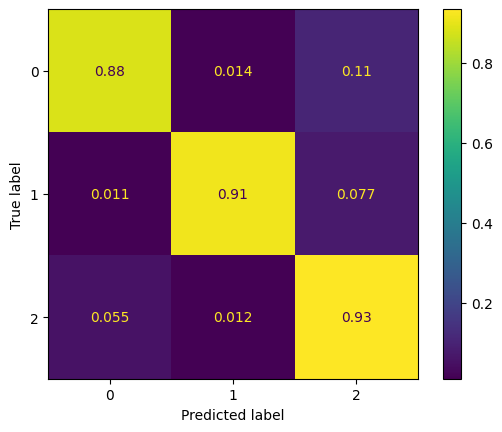

In [70]:
devloader = DataLoader(ConcatDataset([SequencedDatasetv2(idx=idx,condition=condition,sequence_length=CONFIG['SEQUENCE_LENGTH'],batch_size=CONFIG['BATCH_SIZE']) for idx in test_idx[1:2] for condition in ['Vehicle']]),batch_size=1,shuffle=False)
y_true,y_pred,y_logits = get_y_true_y_pred_from_dataloader_and_model(devloader,model,criterion,CONFIG['DEVICE'])
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))

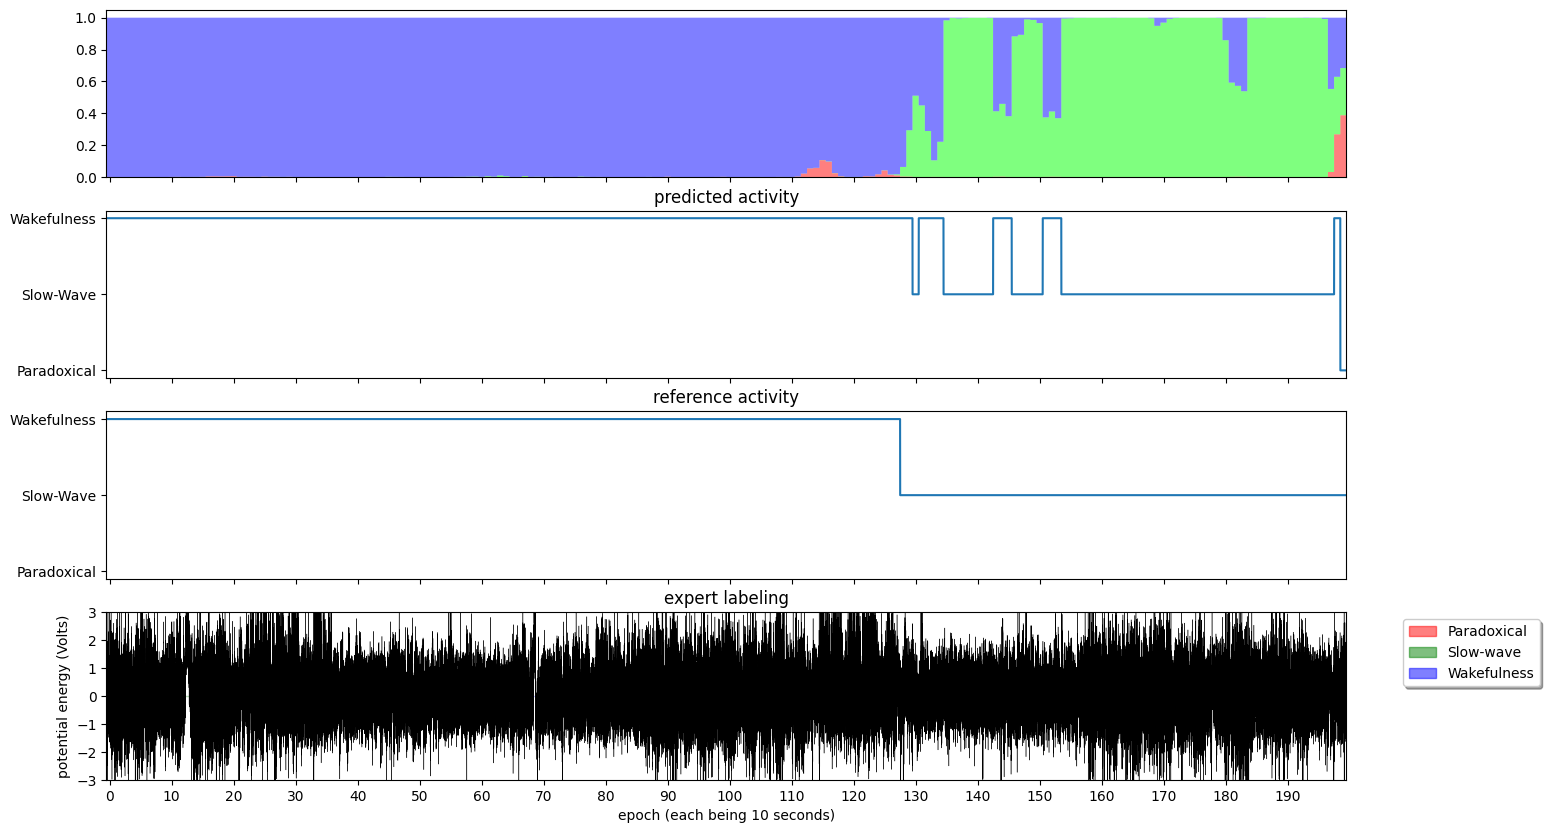

In [71]:
import matplotlib.patches as patches
start = 600
duration = 200

X,y = load_ekyn_pt_robust_scaled(idx=test_idx[0],condition='Vehicle')

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(16,10),dpi=100,sharex=True)

colors = ['red','green','blue']
epochs = []
for i in range(duration):
    stage = int(y.argmax(axis=1)[start+i])
    ax[3].fill_between([i*5000, (i+1)*5000], y1=-.0003, y2=.0003, color=colors[stage], alpha=0.3)
    epochs.append(i*5000+2500)

y_logits_tmp = torch.tensor([[val]*5000 for val in list(y_logits[start:start+duration].numpy())]).flatten(0,1)

ax[0].stackplot(range(len(y_logits_tmp)),y_logits_tmp[:,0],y_logits_tmp[:,1],y_logits_tmp[:,2],colors=['#FF000080','#00FF0080','#0000FF80'])

ax[1].plot(torch.cat([torch.tensor([[val]*5000 for val in list(y_pred[start:start+duration].numpy())]).flatten()]))
ax[1].set_yticks([0,1,2],['Paradoxical','Slow-Wave','Wakefulness'])
ax[1].margins(0,0)
ax[1].set_ylim([-.1,2.1])
ax[1].set_title('predicted activity')

ax[2].plot(torch.cat([torch.tensor([[val]*5000 for val in list(y_true[start:start+duration].numpy())]).flatten()]))
ax[2].set_yticks([0,1,2],['Paradoxical','Slow-Wave','Wakefulness'])
ax[2].margins(0,0)
ax[2].set_ylim([-.1,2.1])
ax[2].set_title('reference activity')

ax[3].plot(X[start:start+duration].flatten(),'black',linewidth=.3)
ax[3].margins(0,0)
ax[3].set_ylim([-3,3])
ax[3].set_ylabel('potential energy (Volts)')
ax[3].set_xticks(epochs[::int(duration/20)],range(duration)[::int(duration/20)]);
ax[3].set_title('expert labeling')

red_patch = patches.Patch(color='red', alpha=0.5, label='Paradoxical')
green_patch = patches.Patch(color='green', alpha=0.5, label='Slow-wave')
blue_patch = patches.Patch(color='blue', alpha=0.5, label='Wakefulness')

plt.legend(handles=[red_patch, green_patch,blue_patch],loc='upper left',bbox_to_anchor=(1.04, 1),fancybox=True, shadow=True, ncol=1)
plt.xlabel('epoch (each being 10 seconds)')
plt.savefig('Sleep3.jpg',bbox_inches='tight')